# <center>**Question 1**



---





In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# path for q1
path_q1 = "/content/drive/MyDrive/Pattern Recognition/Assignment_1/q1"

In [ ]:
#   Segment2_cafe_noise2.wav
#   Segment2_MelEnergy.csv
#   Segment2_STEnergy.csv
#   Segment2_VAD_GT.csv
#   Segment3_cafe_noise1.wav
#   Segment3_MelEnergy.csv
#   Segment3_STEnergy.csv
#   Segment3_VAD_GT.csv




# reading training data and test data
st_train = pd.read_csv(path_q1 +"/Segment2_STEnergy.csv", header=None) 
mel_train = pd.read_csv(path_q1 + "/Segment2_MelEnergy.csv", header=None)
vad_train = pd.read_csv(path_q1 + "/Segment2_VAD_GT.csv", header=None) #label for each data
# 
st_test = pd.read_csv(path_q1 +"/Segment3_STEnergy.csv", header=None)
mel_test = pd.read_csv(path_q1 + "/Segment3_MelEnergy.csv", header=None)
vad_test = pd.read_csv(path_q1 + "/Segment3_VAD_GT.csv", header=None) # label for test data

In [ ]:
# combine the training data into a single DataFrame and test data into another single DataFrame
df_train = pd.DataFrame({'st':st_train[0], 'mel' : mel_train[0], 'gt':vad_train[0]})
df_test = pd.DataFrame({'st':st_test[0], 'mel' : mel_test[0], 'gt':vad_test[0]})


In [ ]:
# function to calculate mean variance and number of data in each class
# of a Dataframe
def central_tendencies(df, train, label):
  # df --> dataFrame, train-> column which central tendency is to be found, label -> column on which grouping is performend
  mean_0 = df.groupby(label).get_group(0)[train].mean()
  var_0 = df.groupby(label).get_group(0)[train].var()

  mean_1 = df.groupby(label).get_group(1)[train].mean()
  var_1 = df.groupby(label).get_group(1)[train].var()

  len_0 = len(df.groupby(label).get_group(0))
  len_1 = len(df.groupby(label).get_group(1))
  return len_0, mean_0, var_0, len_1, mean_1, var_1

# print(central_tendencies(df_train,"st","gt"))

  

In [ ]:
def likelihood_of_class(x,mean,var):
  # essentially we are calculating class conditional density here
  # p(x|Ci) where x is a data point, Ci is a class with mean and var as central tendency
  return np.exp(-(np.square(x-mean)/(2*var)))/np.sqrt(2*np.pi*var)


In [ ]:
def classifier(df_train, df_test, parameter):
  #  df_train -> training data
  #  df_test -> testing data
  #  parameter -> based on this attribute classification of data points will be done
  cols = df_train.columns
  
  len_0, mean_0, var_0, len_1, mean_1, var_1 = central_tendencies(df_train, parameter, cols[2])
  # calculating prior probabilities of the two classes
  prob_0 = len_0/(len_0+len_1)
  prob_1 = len_1/(len_0 + len_1)
  y_pred = []
  for i in range(len(df_test)):
    p0 = prob_0*likelihood_of_class(df_test[parameter][i],mean_0, var_0)
    p1 = prob_1*likelihood_of_class(df_test[parameter][i],mean_1, var_1)
    total_prob_xi = p0 + p1
    # assigning class to the test data points based on posterior probability
    if p0 > p1:
      y_pred.append(0)
    else:
      y_pred.append(1)
  correct_pred = 0
  for i in range(len(y_pred)):
    if y_pred[i] == df_test['gt'][i]:
      correct_pred += 1;
  # returns accuracy of the classification
  return (correct_pred/len(df_test))*100
  

In [ ]:
print(f"accuracy of bayes classifier based on STEnergy is : {classifier(df_train,df_test,'st') :.3f}%")
print(f"accuracy of bayes classifier based on MelEnergy is : {classifier(df_train,df_test,'mel') :.3f}%")

accuracy of bayes classifier based on STEnergy is : 56.727%
accuracy of bayes classifier based on MelEnergy is : 62.545%


In [ ]:
# function to calculate FPR and TPR
def fpr_tpr(df_train, df_test, parameter, threshold, Class):
  #  df_train -> training data
  #  df_test -> testing data
  #  parameter -> based on this attribute classification of data points will be done
  # th-> threshold probability 
  # Class-> 0 : consider 0 as positive class, 1: consider 1 as positive class for fpr and tpr
  cols = df_train.columns
  
  len_0, mean_0, var_0, len_1, mean_1, var_1 = central_tendencies(df_train, parameter, cols[2])
  # calculating prior probabilities of the two classes
  prob_0 = len_0/(len_0+len_1)
  prob_1 = len_1/(len_0 + len_1)
  y_pred = []
  for i in range(len(df_test)):
    p0 = prob_0*likelihood_of_class(df_test[parameter][i],mean_0, var_0)
    p1 = prob_1*likelihood_of_class(df_test[parameter][i],mean_1, var_1)
    total_prob_xi = p0 + p1
    # assigning class to the test data points based on posterior probability
    if(Class==0):
      if p0/total_prob_xi >= threshold:
        y_pred.append(0)
      else:
        y_pred.append(1)
    elif(Class==1):
      if p1 >= threshold:
        y_pred.append(1)
      else:
        y_pred.append(0)
    
  # fp -> false positive ; fn->false negative
  # tp-> true positive    ; tn -> true negative
  fp = 0
  tp = 0
  fn = 0
  tn = 0
  for i in range(len(y_pred)):
      if df_test['gt'][i] == 0 and y_pred[i] == 0:
        tp += 1
      elif df_test['gt'][i] == 1 and y_pred[i] == 1:
        tn += 1
      elif df_test['gt'][i] == 0 and y_pred[i] == 1:
        fn += 1
      else:
        fp += 1
      
  FPR = fp/(fp + tn)
  TPR = tp/(tp + fn)
  return FPR, TPR

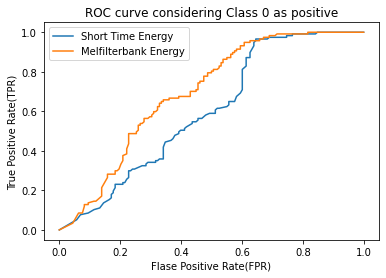

In [ ]:
# Plot the ROC Curve
# Curve between TPR and FPR
thresholds = np.linspace(0,1,1000)
# lists to store tpr and fpr of st
false_pos_st = []
true_pos_st = []
# 
false_pos_mel = []
true_pos_mel = []
for i in range(len(thresholds)):
  # short-time-Energy
  curr_fpr, curr_tpr = fpr_tpr(df_train, df_test, 'st', thresholds[i],0)
  false_pos_st.append(curr_fpr)
  true_pos_st.append(curr_tpr)

  # MEL Energy
  curr_fpr1, curr_tpr1 = fpr_tpr(df_train, df_test, 'mel', thresholds[i],0)
  false_pos_mel.append(curr_fpr1)
  true_pos_mel.append(curr_tpr1)
# Plotting the curve

plt.plot(false_pos_st, true_pos_st)
plt.plot(false_pos_mel, true_pos_mel)
plt.title("ROC curve considering Class 0 as positive")
plt.legend(['Short Time Energy', 'Melfilterbank Energy'])
plt.xlabel("Flase Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.xticks(np.arange(0,1.1,0.2))
plt.yticks(np.arange(0,1.1,0.2))
plt.show()

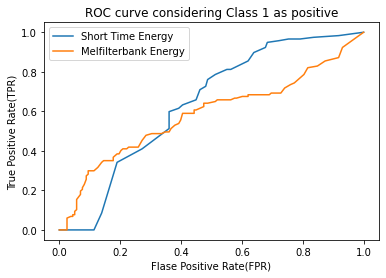

In [ ]:
thresholds = np.linspace(0,10,1000)
# lists to store tpr and fpr of st
false_pos_st = []
true_pos_st = []
# 
false_pos_mel = []
true_pos_mel = []
for i in range(len(thresholds)):
  # short-time-Energy
  curr_fpr, curr_tpr = fpr_tpr(df_train, df_test, 'st', thresholds[i],1)
  false_pos_st.append(curr_fpr)
  true_pos_st.append(curr_tpr)

  # MEL Energy
  curr_fpr1, curr_tpr1 = fpr_tpr(df_train, df_test, 'mel', thresholds[i],1)
  false_pos_mel.append(curr_fpr1)
  true_pos_mel.append(curr_tpr1)
# Plotting the curve

plt.plot(false_pos_st, true_pos_st)
plt.plot(false_pos_mel, true_pos_mel)
plt.title("ROC curve considering Class 1 as positive")
plt.legend(['Short Time Energy', 'Melfilterbank Energy'])
plt.xlabel("Flase Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.xticks(np.arange(0,1.1,0.2))
plt.yticks(np.arange(0,1.1,0.2))
plt.show()

 # <center> **Question 2**



---


In [ ]:
# path
path_q2 = "/content/drive/MyDrive/Pattern Recognition/Assignment_1/q2/"

In [ ]:
# Although it is asked not to use ML library but I need to use sklearn inorder to split training data
from sklearn.model_selection import train_test_split

# Linearly Separable Data

In [ ]:
# read the data
l_cl1 = pd.read_csv(path_q2 + "l_class1.txt", sep = " ", header=None)
l_cl2 = pd.read_csv(path_q2 + "l_class2.txt", sep = " ", header=None)
l_cl3 = pd.read_csv(path_q2 + "l_class3.txt", sep = " ", header=None)

In [ ]:
# split the data into two equal parts randomly
l_cl1_train, l_cl1_test = train_test_split(l_cl1, test_size = 0.5, random_state = 42)
l_cl2_train, l_cl2_test = train_test_split(l_cl2, test_size = 0.5, random_state = 42)
l_cl3_train, l_cl3_test = train_test_split(l_cl3, test_size = 0.5, random_state = 42)

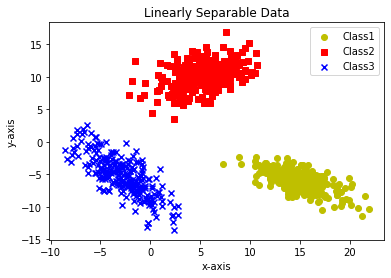

In [ ]:
# visualizing the training data
# scatter plot
plt.scatter(l_cl1_train[0], l_cl1_train[1], c='y',marker='o')
plt.scatter(l_cl2_train[0], l_cl2_train[1], c='r',marker='s')
plt.scatter(l_cl3_train[0], l_cl3_train[1], c='b',marker='x')
plt.legend(['Class1', 'Class2', 'Class3'])
plt.title('Linearly Separable Data')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

In [ ]:
# combine all the train and test data into one and assign its correct label
l_cl1_train[2] = 1 # class1
l_cl2_train[2] = 2 # class2
l_cl3_train[2] = 3 # class3
# test
l_cl1_test[2] = 1 # class1
l_cl2_test[2] = 2 # class2
l_cl3_test[2] = 3 # class3

In [ ]:
# concatenating training data
l_train = pd.concat([l_cl1_train,l_cl2_train])
l_train = pd.concat([l_train, l_cl3_train])
l_train.reset_index(drop=True, inplace=True)
l_train.rename(columns = {0 :'attr1', 1 :'attr2', 2 : 'label'}, inplace=True)

In [ ]:
# concatenating test data
l_test = pd.concat([l_cl1_test,l_cl2_test])
l_test = pd.concat([l_test, l_cl3_test])
l_test.reset_index(drop=True, inplace=True)
l_test.rename(columns = {0 :'attr1', 1 :'attr2', 2 : 'label'}, inplace=True)

In [ ]:
# l_train.groupby('label').get_group(3).cov().values[0:2, 0:2] 
# l_train.groupby('label').get_group(3).mean().values[0:2]


In [ ]:
def parameters_of_classifier(df_train):
  # mean vector and co-variance matrix
  mean_1 = df_train.groupby('label').get_group(1).mean().values[0:2]
  cov_1 = df_train.groupby('label').get_group(1).cov().values[0:2, 0:2]
  # 
  mean_2 = df_train.groupby('label').get_group(2).mean().values[0:2]
  cov_2 = df_train.groupby('label').get_group(2).cov().values[0:2, 0:2]
  #
  mean_3 = df_train.groupby('label').get_group(3).mean().values[0:2]
  cov_3 = df_train.groupby('label').get_group(3).cov().values[0:2, 0:2]
  # print(mean_1)
  # print()
  # print(mean_3)
  return mean_1, cov_1, mean_2, cov_2, mean_3, cov_3



In [ ]:
def conditional_density(test_i, mean_1, mean_2, mean_3, cov_1, cov_2, cov_3):
  # we'll be providing with new covariance of each class based on the classifier we are using
  inv_1 = np.linalg.inv(cov_1)
  inv_2 = np.linalg.inv(cov_2)
  inv_3 = np.linalg.inv(cov_3)
  det_1 = np.linalg.det(cov_1)
  det_2 = np.linalg.det(cov_2)
  det_3 = np.linalg.det(cov_3)
  dim = len(mean_1)
  # print(test_i)
 
  # print(mean_1)
  # x-mean vector for all classes
  diff_1 = test_i - mean_1
  diff_2 = test_i - mean_2
  diff_3 = test_i - mean_3
  # comparision of conditional densities will give the comparision of posterior probabilities of classe
  # It is because of the reason that prior probabiltity of each class is same
  p1 = np.exp(-(np.matmul((np.matmul(diff_1.T, inv_1)), diff_1))*0.5)*(1/(((2*np.pi)**(dim/2))*(det_1)**0.5))
  p2 = np.exp(-(np.matmul((np.matmul(diff_2.T, inv_2)), diff_2))*0.5)*(1/(((2*np.pi)**(dim/2))*(det_2)**0.5))
  p3 = np.exp(-(np.matmul((np.matmul(diff_3.T, inv_3)), diff_3))*0.5)*(1/(((2*np.pi)**(dim/2))*(det_3)**0.5))

  return p1,p2,p3

In [ ]:
def Classifier1(df_train, df_test):
  # model building for classifier 1
  mean_1, cov_1, mean_2, cov_2, mean_3, cov_3 = parameters_of_classifier(df_train)
  # Covariance for all classes is Iσ^2, the average of the sample variances for all dimensions, for all classes
  sigma_sq = ((cov_1[0][0] + cov_1[1][1]) + (cov_2[0][0] + cov_2[1][1]) + (cov_2[0][0] + cov_2[1][1]))/6
  new_cov = np.array([[sigma_sq, 0], [0, sigma_sq]])
  # this new covariance matrix will be same for all the classes
  # print(new_cov)
  # make prediction based on likelihood
  y_pred = []
  for i in range(len(df_test)):
    x_test_i = df_test.iloc[i].values[0:2]
    pred_idx = np.argmax(conditional_density(x_test_i,mean_1,mean_2,mean_3,new_cov,new_cov,new_cov)) 
    y_pred.append(pred_idx + 1)
  
  return y_pred




In [ ]:
def Classifier2(df_train, df_test):
  # model building for classifier 1
  mean_1, cov_1, mean_2, cov_2, mean_3, cov_3 = parameters_of_classifier(df_train)
  # Covariance the average of the sample covariances  for all classes
  
  new_cov = (cov_1 + cov_2 + cov_3)/3
  # this new covariance matrix will be same for all the classes
  # print(new_cov)
  # make prediction based on likelihood
  y_pred = []
  for i in range(len(df_test)):
    x_test_i = df_test.iloc[i].values[0:2]
    pred_idx = np.argmax(conditional_density(x_test_i,mean_1,mean_2,mean_3,new_cov,new_cov,new_cov)) 
    y_pred.append(pred_idx + 1)
  
  return y_pred

In [ ]:
def Classifier3(df_train, df_test):
  # model building for classifier 1
  mean_1, cov_1, mean_2, cov_2, mean_3, cov_3 = parameters_of_classifier(df_train)
 
  # diagonal covariance matrix for each class
  cov_1 = np.array([[cov_1[0][0], 0],[0, cov_1[1][1]]])
  cov_2 = np.array([[cov_2[0][0], 0],[0, cov_2[1][1]]])
  cov_3 = np.array([[cov_3[0][0], 0],[0, cov_3[1][1]]])
  
  # make prediction based on likelihood
  y_pred = []
  for i in range(len(df_test)):
    x_test_i = df_test.iloc[i].values[0:2]
    pred_idx = np.argmax(conditional_density(x_test_i,mean_1,mean_2,mean_3,cov_1, cov_2, cov_3)) 
    y_pred.append(pred_idx + 1)
  
  return y_pred

In [ ]:
def Classifier4(df_train, df_test):
  # model building for classifier 1
  mean_1, cov_1, mean_2, cov_2, mean_3, cov_3 = parameters_of_classifier(df_train)
  
  # sample covariance matrix is the covariance matrix for each class
  
  # make prediction based on likelihood
  y_pred = []
  for i in range(len(df_test)):
    x_test_i = df_test.iloc[i].values[0:2]
    pred_idx = np.argmax(conditional_density(x_test_i,mean_1,mean_2,mean_3,cov_1,cov_2,cov_3)) 
    y_pred.append(pred_idx + 1)
  
  return y_pred

In [ ]:
def preformance_measure_helper(y_pred, y_test, pos_class):
  acc, pre, rec, fsc = 0, 0, 0, 0
  # considering class1 as positive
  tp, fp, tn, fn = 0, 0, 0, 0
  for i in range(len(y_pred)):
    if y_pred[i] == pos_class and y_test.iloc[i] == pos_class:
      tp += 1
    elif y_pred[i] != pos_class and y_test.iloc[i] == pos_class:
      fn += 1
    elif y_pred[i] == pos_class and y_test.iloc[i] != pos_class:
      fp += 1
    else:
      tn += 1
  acc = (tn + tp)/(tn+tp+fn+fp)
  pre = tp/(tp+fp)
  rec = tp/(tp+fn)
  fsc = (2*pre*rec)/(pre + rec) 
  return acc, pre, rec, fsc

In [ ]:
#  Accuracy, Precision, Recall and F-score for each classifier
def performance_measure(df_train, df_test, classfier_name):
  y_pred = classfier_name(df_train, df_test)
  # print(np.array(y_pred))

  acc, pre, rec, fsc = 0, 0, 0, 0
  # take average of all the precision measures after considering each classes as positive one by one
  for i in range(1,4,1):
    curr_acc, curr_pre, curr_rec, curr_fsc = preformance_measure_helper(y_pred,df_test['label'],i)
    acc += curr_acc
    pre += curr_pre
    rec += curr_rec
    fsc += curr_fsc
  acc = acc/3
  pre /= 3
  rec /= 3
  fsc /= 3
  return acc, pre, rec, fsc

    

In [ ]:
performance_measure(l_train,l_test, Classifier3) 

(0.9991111111111112, 0.99867197875166, 0.9986666666666667, 0.9986666613333121)

In [ ]:
def plot_decision_boundaries(df_train, df_test, classifier_name, Title):
  Y = df_test['label']
  X = df_test[['attr1','attr2']]

  # finding parameters for plotting boundaries
  # to be safer side we define boundary +1 and -1 of the min and max from the data point
  min_x, max_x = X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1
  min_y, max_y = X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1

  # generate data points in between these accquired boundaries
  x1_grid = np.arange(min_x, max_x, 0.1)
  x2_grid = np.arange(min_y, max_y, 0.1)

  # now use np.meshgrid() to make all lines and rows of the grid
  xx, yy = np.meshgrid(x1_grid, x2_grid)

  #  flatten each grid vector
  vec_x, vec_y = xx.flatten(), yy.flatten()
  vec_x, vec_y = vec_x.reshape((len(vec_x), 1)), vec_y.reshape((len(vec_y), 1))
  # horizontal stack vectors to create x1,x2 input for the model
  grid = pd.DataFrame(np.hstack((vec_x, vec_y)))
  
  # Predictions from the classifier to make the plot
  y_pred = classifier_name(df_train, grid)
  y_pred = np.array(y_pred)
  zz = y_pred.reshape(xx.shape)
  
  # plot the grid of x, y and z values as a surface
  plt.contourf(xx, yy, zz, cmap = 'Paired')
  # create scatter plot for samples from each class
  X = np.array(X)
  for cls in range(1,4):
    # get row indexes for samples with this class
    i = np.where(Y == cls)
    # create scatter of these samples
    plt.scatter(X[i, 0], X[i, 1], cmap = 'Paired')
  
  plt.title(Title)
  plt.xlabel("x-axis")
  plt.ylabel("y-axis")
  plt.show()


## **Classification model has been built. Now we need to use them to answer assignment questions**

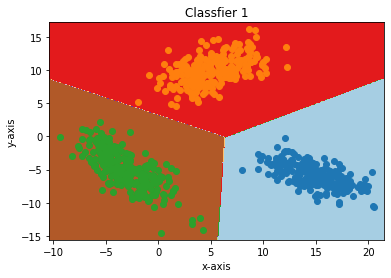

In [ ]:
# plot decision boundary for classifier 1
plot_decision_boundaries(l_train, l_test, Classifier1, 'Classfier 1')

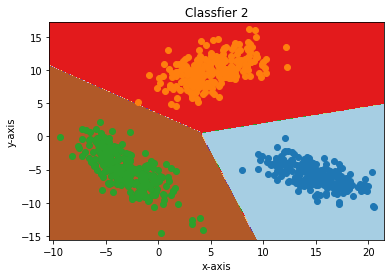

In [ ]:
# plot decision boundary for classifier 2
plot_decision_boundaries(l_train, l_test, Classifier2, 'Classfier 2')

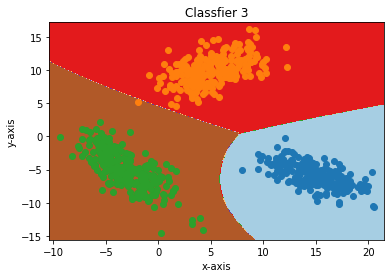

In [ ]:
# plot decision boundary for classifier 3
plot_decision_boundaries(l_train, l_test, Classifier3, 'Classfier 3')

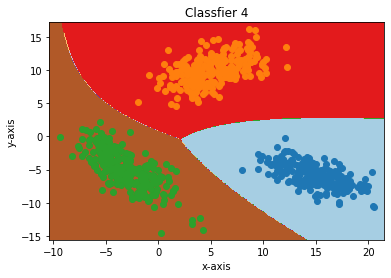

In [ ]:
# plot decision boundary for classifier 4
plot_decision_boundaries(l_train, l_test, Classifier4, 'Classfier 4')

In [ ]:
# printing the performance statistics of all the classifiers in a table
p_class1 = np.array(performance_measure(l_train,l_test, Classifier1)) 
p_class2 = np.array(performance_measure(l_train,l_test, Classifier2)) 
p_class3 = np.array(performance_measure(l_train,l_test, Classifier3)) 
p_class4 = np.array(performance_measure(l_train,l_test, Classifier4)) 

p_data_l = np.array([p_class1, p_class2, p_class3, p_class4])
column_values = ['Accuracy', 'Precision', 'Recall', 'F-score']
index_values = ['Classifier_1', 'Classifier_2', 'Classifier_3', 'Classifier_4']
performance_table = pd.DataFrame(data = p_data_l, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
performance_table

,Accuracy,Precision,Recall,F-score
Classifier_1,1.000000,1.000000,1.000000,1.000000
Classifier_2,1.000000,1.000000,1.000000,1.000000
Classifier_3,0.999111,0.998672,0.998667,0.998667
Classifier_4,1.000000,1.000000,1.000000,1.000000


In [ ]:
# print summary of parameters for classifier1
def sum_classifier(df_train, df_test, classifier_name):
  mean_1, cov_1, mean_2, cov_2, mean_3, cov_3 = parameters_of_classifier(df_train)
  # 
  if classifier_name == 1:
    sigma_sq = ((cov_1[0][0] + cov_1[1][1]) + (cov_2[0][0] + cov_2[1][1]) + (cov_2[0][0] + cov_2[1][1]))/6
    new_cov = np.array([[sigma_sq, 0], [0, sigma_sq]])
    cov_1, cov_2, cov_3 = new_cov, new_cov, new_cov
    means_cl1 = np.array([mean_1, mean_2, mean_3])
    means_cl1 = pd.DataFrame(data = means_cl1, index = ['Class1', 'Class2', 'Class3'], columns = ['mean_attr1', 'mean_attr2'])
  
  elif classifier_name == 2:
    new_cov = (cov_1 + cov_2 + cov_3)/3
    cov_1, cov_2, cov_3 = new_cov, new_cov, new_cov
    means_cl1 = np.array([mean_1, mean_2, mean_3])
    means_cl1 = pd.DataFrame(data = means_cl1, index = ['Class1', 'Class2', 'Class3'], columns = ['mean_attr1', 'mean_attr2'])
  
  elif classifier_name == 3:
    cov_1 = np.array([[cov_1[0][0], 0],[0, cov_1[1][1]]])
    cov_2 = np.array([[cov_2[0][0], 0],[0, cov_2[1][1]]])
    cov_3 = np.array([[cov_3[0][0], 0],[0, cov_3[1][1]]])
    means_cl1 = np.array([mean_1, mean_2, mean_3])
    means_cl1 = pd.DataFrame(data = means_cl1, index = ['Class1', 'Class2', 'Class3'], columns = ['mean_attr1', 'mean_attr2'])
  else:
    means_cl1 = np.array([mean_1, mean_2, mean_3])
    means_cl1 = pd.DataFrame(data = means_cl1, index = ['Class1', 'Class2', 'Class3'], columns = ['mean_attr1', 'mean_attr2'])
  print(f'# Mean Summary for Classifier {classifier_name}')
  print(means_cl1)
  # 
  print(f'\n# Covariance Matrix used for classifier {classifier_name}\n')
  print('\nFor Class 1')
  print(cov_1)
  print('\nFor Class 2')
  print(cov_2)
  print('\nFor Class 3')
  print(cov_3)



In [ ]:
sum_classifier(l_train, l_test, 1)

# Mean Summary for Classifier 1
        mean_attr1  mean_attr2
Class1   14.869206   -6.013958
Class2    5.269118   10.218500
Class3   -2.796475   -5.222994

# Covariance Matrix used for classifier 1


For Class 1
[[4.87758835 0.        ]
 [0.         4.87758835]]

For Class 2
[[4.87758835 0.        ]
 [0.         4.87758835]]

For Class 3
[[4.87758835 0.        ]
 [0.         4.87758835]]


In [ ]:
sum_classifier(l_train, l_test, 2)

# Mean Summary for Classifier 2
        mean_attr1  mean_attr2
Class1   14.869206   -6.013958
Class2    5.269118   10.218500
Class3   -2.796475   -5.222994

# Covariance Matrix used for classifier 2


For Class 1
[[ 5.85869274 -2.01258645]
 [-2.01258645  5.40159017]]

For Class 2
[[ 5.85869274 -2.01258645]
 [-2.01258645  5.40159017]]

For Class 3
[[ 5.85869274 -2.01258645]
 [-2.01258645  5.40159017]]


In [ ]:
sum_classifier(l_train, l_test, 3)

# Mean Summary for Classifier 3
        mean_attr1  mean_attr2
Class1   14.869206   -6.013958
Class2    5.269118   10.218500
Class3   -2.796475   -5.222994

# Covariance Matrix used for classifier 3


For Class 1
[[5.77988397 0.        ]
 [0.         2.80134335]]

For Class 2
[[6.11840592 0.        ]
 [0.         4.22374546]]

For Class 3
[[5.67778833 0.        ]
 [0.         9.17968168]]


In [ ]:
sum_classifier(l_train, l_test, 4)

# Mean Summary for Classifier 4
        mean_attr1  mean_attr2
Class1   14.869206   -6.013958
Class2    5.269118   10.218500
Class3   -2.796475   -5.222994

# Covariance Matrix used for classifier 4


For Class 1
[[ 5.77988397 -2.60577901]
 [-2.60577901  2.80134335]]

For Class 2
[[6.11840592 2.10008546]
 [2.10008546 4.22374546]]

For Class 3
[[ 5.67778833 -5.53206581]
 [-5.53206581  9.17968168]]


# <center> **Non Linearly Separable Data**

---






In [ ]:
# read the data
nl_cl1 = pd.read_csv(path_q2 + "nl_class1.txt", sep = " ", header=None)
nl_cl2 = pd.read_csv(path_q2 + "nl_class2.txt", sep = " ", header=None)
nl_cl3 = pd.read_csv(path_q2 + "nl_class3.txt", sep = " ", header=None)

In [ ]:
# split the data into two equal parts randomly
nl_cl1_train, nl_cl1_test = train_test_split(nl_cl1, test_size = 0.5, random_state = 42)
nl_cl2_train, nl_cl2_test = train_test_split(nl_cl2, test_size = 0.5, random_state = 42)
nl_cl3_train, nl_cl3_test = train_test_split(nl_cl3, test_size = 0.5, random_state = 42)

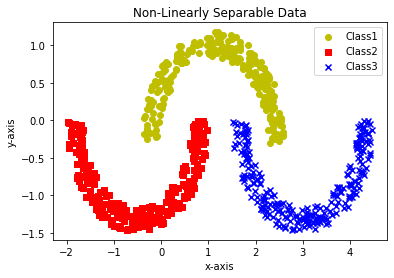

In [ ]:
# visualizing the training data
# scatter plot
plt.scatter(nl_cl1_train[0], nl_cl1_train[1], c='y',marker='o')
plt.scatter(nl_cl2_train[0], nl_cl2_train[1], c='r',marker='s')
plt.scatter(nl_cl3_train[0], nl_cl3_train[1], c='b',marker='x')
plt.legend(['Class1', 'Class2', 'Class3'])
plt.title('Non-Linearly Separable Data')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.show()

In [ ]:
# combine all the train and test data into one and assign its correct label
nl_cl1_train[2] = 1 # class1
nl_cl2_train[2] = 2 # class2
nl_cl3_train[2] = 3 # class3
# test
nl_cl1_test[2] = 1 # class1
nl_cl2_test[2] = 2 # class2
nl_cl3_test[2] = 3 # class3

In [ ]:
# concatenating training data
nl_train = pd.concat([nl_cl1_train,nl_cl2_train])
nl_train = pd.concat([nl_train, nl_cl3_train])
nl_train.reset_index(drop=True, inplace=True)
nl_train.rename(columns = {0 :'attr1', 1 :'attr2', 2 : 'label'}, inplace=True)

In [ ]:
# concatenating test data
nl_test = pd.concat([nl_cl1_test,nl_cl2_test])
nl_test = pd.concat([nl_test, nl_cl3_test])
nl_test.reset_index(drop=True, inplace=True)
nl_test.rename(columns = {0 :'attr1', 1 :'attr2', 2 : 'label'}, inplace=True)

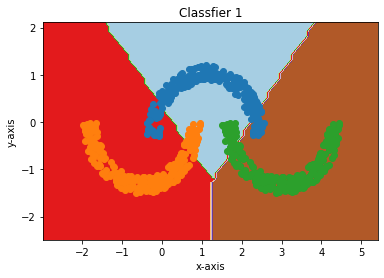

In [ ]:
# plot decision boundary for classifier 1 and Non -Linearly separable data
plot_decision_boundaries(nl_train, nl_test, Classifier1, 'Classfier 1')

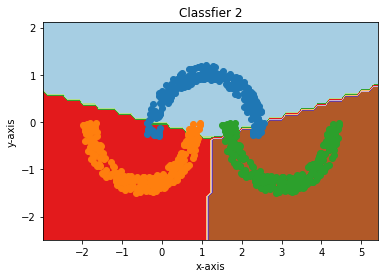

In [ ]:
# plot decision boundary for classifier 2 and Non -Linearly separable data
plot_decision_boundaries(nl_train, nl_test, Classifier2, 'Classfier 2')

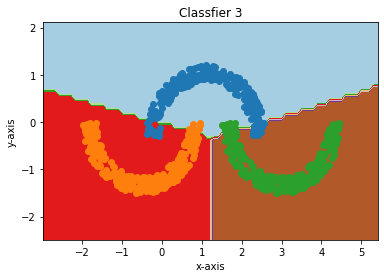

In [ ]:
# plot decision boundary for classifier 3 and Non -Linearly separable data
plot_decision_boundaries(nl_train, nl_test, Classifier3, 'Classfier 3')

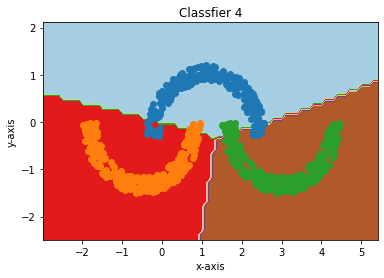

In [ ]:
# plot decision boundary for classifier 4 and Non -Linearly separable data
plot_decision_boundaries(nl_train, nl_test, Classifier4, 'Classfier 4')

In [ ]:
# printing the performance statistics of all the classifiers in a table
p_nclass1 = np.array(performance_measure(nl_train,nl_test, Classifier1)) 
p_nclass2 = np.array(performance_measure(nl_train,nl_test, Classifier2)) 
p_nclass3 = np.array(performance_measure(nl_train,nl_test, Classifier3)) 
p_nclass4 = np.array(performance_measure(nl_train,nl_test, Classifier4)) 

p_data_nl = np.array([p_nclass1, p_nclass2, p_nclass3, p_nclass4])
column_values = ['Accuracy', 'Precision', 'Recall', 'F-score']
index_values = ['Classifier_1', 'Classifier_2', 'Classifier_3', 'Classifier_4']
performance_table_nl = pd.DataFrame(data = p_data_nl, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
performance_table_nl

,Accuracy,Precision,Recall,F-score
Classifier_1,0.880000,0.822273,0.820000,0.820946
Classifier_2,0.942222,0.913361,0.913333,0.913295
Classifier_3,0.944000,0.915506,0.916000,0.915634
Classifier_4,0.943111,0.914341,0.914667,0.914355


In [ ]:
# summary of input parameter for model building for each classifier
sum_classifier(nl_train, nl_test, 1)

# Mean Summary for Classifier 1
        mean_attr1  mean_attr2
Class1    1.223598    0.543296
Class2   -0.474108   -0.833736
Class3    3.025892   -0.833736

# Covariance Matrix used for classifier 1


For Class 1
[[0.53988366 0.        ]
 [0.         0.53988366]]

For Class 2
[[0.53988366 0.        ]
 [0.         0.53988366]]

For Class 3
[[0.53988366 0.        ]
 [0.         0.53988366]]


In [ ]:
sum_classifier(nl_train, nl_test, 2)

# Mean Summary for Classifier 2
        mean_attr1  mean_attr2
Class1    1.223598    0.543296
Class2   -0.474108   -0.833736
Class3    3.025892   -0.833736

# Covariance Matrix used for classifier 2


For Class 1
[[0.90199944 0.01500936]
 [0.01500936 0.17776788]]

For Class 2
[[0.90199944 0.01500936]
 [0.01500936 0.17776788]]

For Class 3
[[0.90199944 0.01500936]
 [0.01500936 0.17776788]]


In [ ]:
sum_classifier(nl_train, nl_test, 3)

# Mean Summary for Classifier 3
        mean_attr1  mean_attr2
Class1    1.223598    0.543296
Class2   -0.474108   -0.833736
Class3    3.025892   -0.833736

# Covariance Matrix used for classifier 3


For Class 1
[[0.90863983 0.        ]
 [0.         0.1530274 ]]

For Class 2
[[0.89867924 0.        ]
 [0.         0.19013813]]

For Class 3
[[0.89867924 0.        ]
 [0.         0.19013813]]


In [ ]:
sum_classifier(nl_train, nl_test, 4)

# Mean Summary for Classifier 4
        mean_attr1  mean_attr2
Class1    1.223598    0.543296
Class2   -0.474108   -0.833736
Class3    3.025892   -0.833736

# Covariance Matrix used for classifier 4


For Class 1
[[ 0.90863983 -0.02090378]
 [-0.02090378  0.1530274 ]]

For Class 2
[[0.89867924 0.03296593]
 [0.03296593 0.19013813]]

For Class 3
[[0.89867924 0.03296593]
 [0.03296593 0.19013813]]
